In [7]:
import nest_asyncio
import stan
import numpy as np
import pandas as pd
from os import path
import sys
sys.path.append('/root/capsule/aind-beh-ephys-analysis/code/beh_ephys_analysis/utils')
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from beh_functions import parseSessionID, session_dirs, makeSessionDF
from RLmodels import QLearningModel
# from RLmodels import qLearningModel_5params_simNoPlot
from RLmodels import RestlessBanditDecoupled
from RLmodels import QLearningModelSim, myPairPlot, getSessionFitParams
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import re
from scipy.stats import norm
from scipy.stats import halfcauchy
from scipy.stats import cauchy
from sklearn.linear_model import LinearRegression
import pickle
import json
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import statsmodels.api as sm
import os
from aind_dynamic_foraging_basic_analysis import plot_foraging_session
from beh_utils import*
import statsmodels.api as sm
import json
import ast

In [8]:
# load fitted samples
animalID = '754897'
model_name = 'stan_qLearning_5params'
name = animalID + '/' + model_name
saveDir = path.expanduser('~/capsule/scratch/'+name)
dataDir = path.expanduser('~/capsule/data/foraging_nwb_bonsai/')
if not os.path.exists(saveDir):
    print(f'Model {name} not found.')
else:
    paramsFit = pd.read_csv(saveDir+'/paramsFit.csv', index_col=0)
    summary = pd.read_csv(saveDir+'/summary.csv', index_col=0)
    param_names = list(paramsFit.columns)
    ani_session_data = pd.read_csv(saveDir+'/ani_session_data.csv')

    with open(saveDir+'/samples', 'rb') as pickle_file:
        fit = pickle.load(pickle_file)

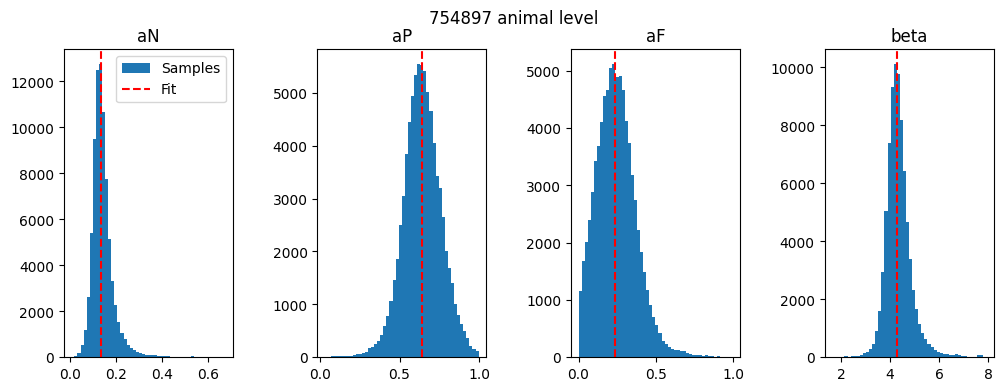

In [9]:
# animal level parameters
focus = 'median' # or 'mode' or 'mad'or 'mean'
paramsAniFit = []
paramNamesNoBias = []
for paramName in param_names:
    if 'bias' not in paramName:
        curr = summary.loc[summary.index.str.startswith(f'mu_{paramName}'), focus].values[0]
        paramsAniFit.append(curr)
        paramNamesNoBias.append(paramName)
paramsAniFit = dict(zip(paramNamesNoBias, paramsAniFit)) 
# compare animal level sim, fit and distribution
fig = plt.figure(figsize=(12, 4))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for paramInd, paramName in enumerate(paramNamesNoBias):
    currSamples = fit[f'mu_{paramName}'].flatten()
    plt.subplot(1, len(paramNamesNoBias), paramInd+1)
    plt.hist(currSamples, 50, label='Samples')
    plt.axvline(paramsAniFit[paramName], color = 'r', ls = '--', label = 'Fit')
    plt.title(paramName)
    if paramInd == 0:
        plt.legend()

plt.suptitle(f'{animalID} animal level')
fig.savefig(f'{saveDir}/{animalID}_{focus}_animal_Level_samples.pdf')


In [10]:
def sampleParams(fit, sessionInd, sampNum, aniLevel = True, randomSeed = 1):
    np.random.seed(randomSeed)
    sampInds = np.random.random_integers(0, np.shape(fit['log_lik'])[1]-1, sampNum)
    sessionParams = []

    for paramName in param_names:
        currSamples = fit[paramName]
        currParams = currSamples[sessionInd, sampInds]
        sessionParams.append(currParams)

    sessionParams = np.array(sessionParams).T

    return sessionParams

In [11]:
class meanDVinfer:
    def __init__(self, params, **kwargs):
        self.params = params
        self.paramsMean = np.mean(params, 0)
        self.sampNum = np.shape(self.params)[0]
        self.LHSamp = np.ones((self.sampNum, 1))
        self.QSamp = list([None]*self.sampNum)
        self.peSamp =  list([None]*self.sampNum)
        self.pChoiceSamp =  list([None]*self.sampNum)
        self.LH = []
        self.Q = []
        self.pe = []
        self.pChoice = []
        self.choices = []
        self.outcomes = []

    def inferSamps(self, choices, outcomes):
        for sampInd in range(self.sampNum):
            self.choices = choices
            self.outcomes = outcomes
            rlModel = QLearningModel(self.params[sampInd,])
            rlModel.fit(np.array(choices), np.array(outcomes))
            self.LHSamp[sampInd] = rlModel.LH
            self.QSamp[sampInd] = rlModel.Q
            self.peSamp[sampInd] = rlModel.pe
            self.pChoiceSamp[sampInd] = rlModel.pChoice
            
        self.LH = np.mean(np.array(self.LHSamp))
        self.Q = np.mean(np.array(self.QSamp), 0)
        self.pe = np.mean(np.array(self.peSamp), 0)
        self.pChoice = np.mean(np.array(self.pChoiceSamp), 0)
        self.maxTrial = np.shape(self.choices)[0]

    def plot(self):
        fig = plt.figure(figsize=(20, 6))
        plt.subplot(4, 1, 1)
        x = np.tile(np.array(range(self.maxTrial)), (2, 1))
        y = np.concatenate((np.zeros((1,self.maxTrial)), (DVs.choices[:, np.newaxis].T-0.5) * (self.outcomes[:, np.newaxis].T + 1)), axis=0)
        plt.plot(np.array(range(self.maxTrial)), self.Q[:,1] - self.Q[:,0], color = [0.7, 0.7, 0.7])
        plt.plot(x, y, c = 'k', lw = 0.5);
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(np.array(range(self.maxTrial)), self.Q[:,0], c = 'm' , label = 'L')
        plt.plot(np.array(range(self.maxTrial)), self.Q[:,1], c = 'c', label = 'R')

        plt.suptitle(self.paramsMean)
        return fig


Extracting session data for session  behavior_754897_2025-03-11_12-07-41


/tmp/ipykernel_2084/3045810984.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 79999 + 1) instead
  sampInds = np.random.random_integers(0, np.shape(fit['log_lik'])[1]-1, sampNum)
/tmp/ipykernel_2084/2324367069.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Extracting session data for session  behavior_754897_2025-03-12_12-23-15


/tmp/ipykernel_2084/3045810984.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 79999 + 1) instead
  sampInds = np.random.random_integers(0, np.shape(fit['log_lik'])[1]-1, sampNum)
/tmp/ipykernel_2084/2324367069.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Extracting session data for session  behavior_754897_2025-03-13_11-20-42


/tmp/ipykernel_2084/3045810984.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 79999 + 1) instead
  sampInds = np.random.random_integers(0, np.shape(fit['log_lik'])[1]-1, sampNum)
/tmp/ipykernel_2084/2324367069.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Extracting session data for session  behavior_754897_2025-03-14_11-28-53


/tmp/ipykernel_2084/3045810984.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 79999 + 1) instead
  sampInds = np.random.random_integers(0, np.shape(fit['log_lik'])[1]-1, sampNum)
/tmp/ipykernel_2084/2324367069.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Extracting session data for session  behavior_754897_2025-03-15_11-32-18


/tmp/ipykernel_2084/3045810984.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 79999 + 1) instead
  sampInds = np.random.random_integers(0, np.shape(fit['log_lik'])[1]-1, sampNum)
/tmp/ipykernel_2084/2324367069.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


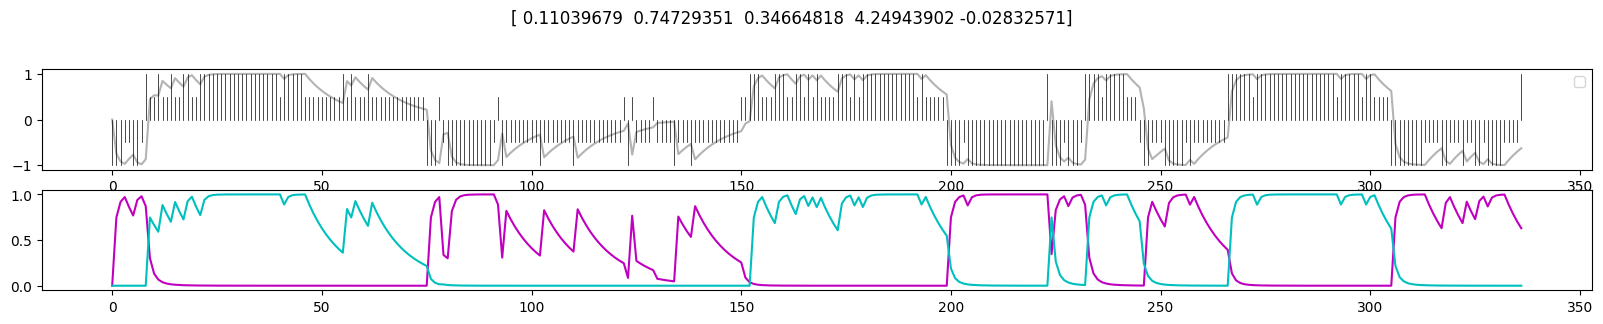

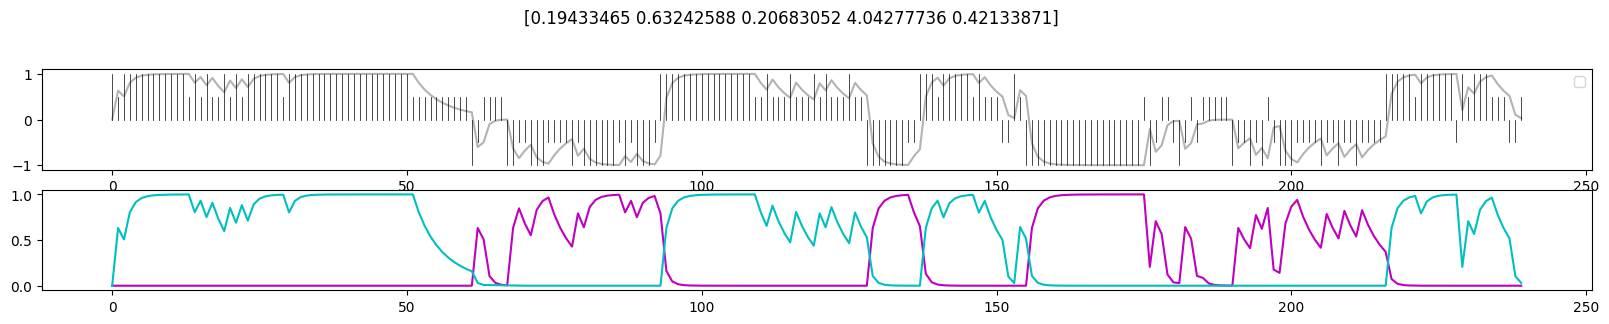

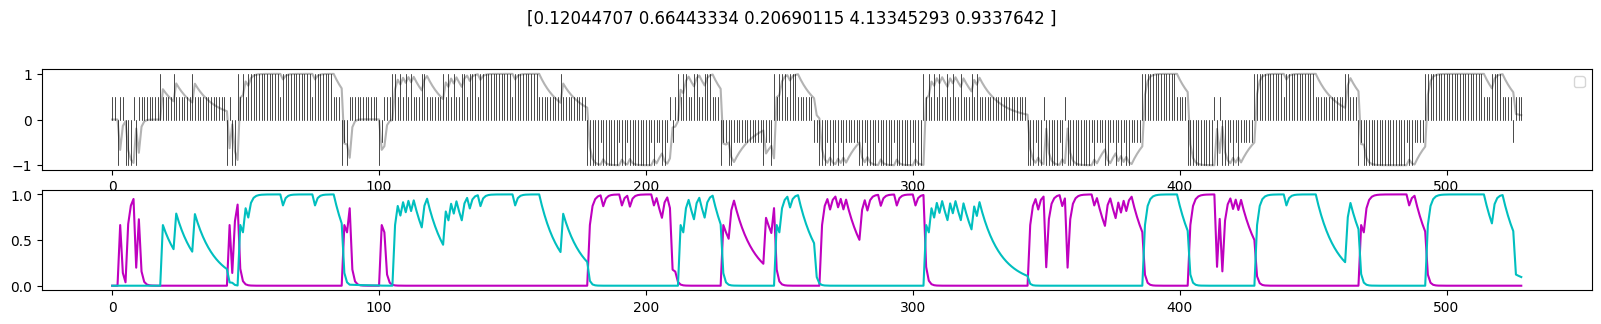

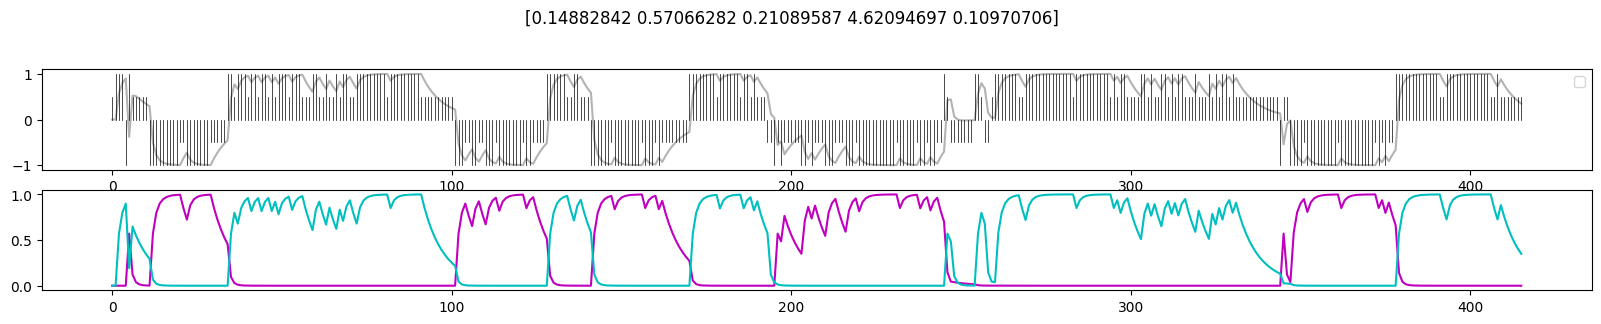

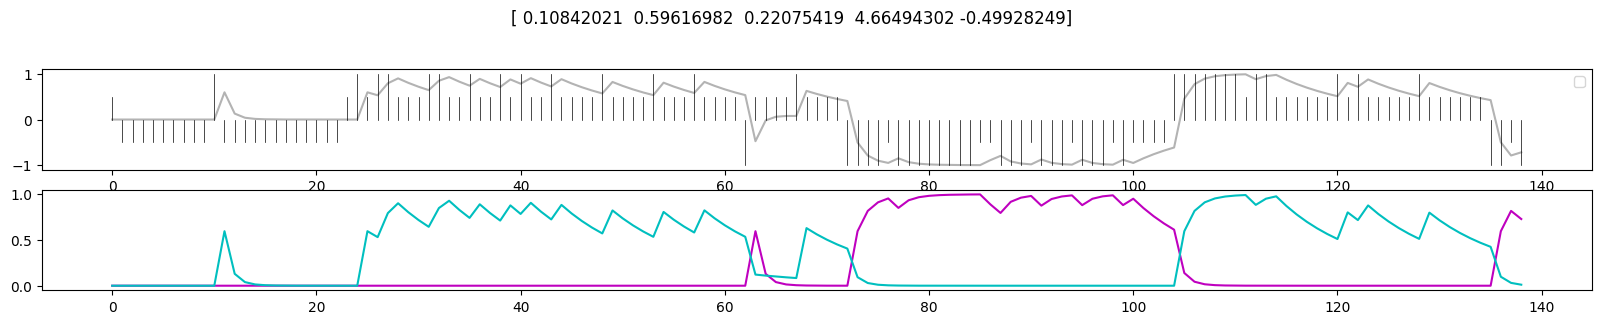

In [12]:
sampNum = 500
params_session = []
for sessionInd in range(len(ani_session_data['session_id'])):  
    session = ani_session_data['session_id'][sessionInd]
    print('Extracting session data for session ', session)
    session_dir = session_dirs(session)
    nwb_file = os.path.join(session_dir['beh_fig_dir'], session + '.nwb')
    nwb = load_nwb_from_filename(nwb_file)
    trial_count = len(nwb.trials.to_dataframe())
    curr_cut = ast.literal_eval(ani_session_data['session_cut'][sessionInd])
    
    # convert curr_cut to start and end removal
    curr_cut[1] = trial_count - curr_cut[1]
    choice_tbl = makeSessionDF(nwb, curr_cut)

    choices = choice_tbl['choices'].values
    outcomes = choice_tbl['outcomes'].values

    # fitted
    sessionParams = sampleParams(fit, sessionInd, sampNum, randomSeed=sessionInd, aniLevel=False)
    DVs = meanDVinfer(sessionParams)
    DVs.inferSamps(choices, outcomes)

    # save session model dv
    Q_r = DVs.Q[:,1]
    Q_l = DVs.Q[:,0]
    pe = DVs.pe
    pChoice = DVs.pChoice
    params_mean = DVs.paramsMean
    session_model_dv = {'outcome': outcomes, 'choice': choices, 'Q_r': Q_r, 'Q_l': Q_l, 'pe': pe, 'pChoice': pChoice}
    session_model_dv = pd.DataFrame(session_model_dv)
    session_model_dv.to_csv(saveDir + '/' + ani_session_data['session_id'][sessionInd] + '_session_model_dv.csv')

    QdiffFit = DVs.Q[:,1] - DVs.Q[:,0]
    QsumFit = DVs.Q[:,1] + DVs.Q[:,0]

    # plot
    fig = DVs.plot()
    fig.savefig(saveDir + '/' + ani_session_data['session_id'][sessionInd] + '_session_model_dv.pdf')   

    # save params
    params_session.append(params_mean)

params_session = np.array(params_session)
params_session = pd.DataFrame(params_session, columns = param_names)
params_session['session_id'] = ani_session_data['session_id']
params_session.to_csv(saveDir + '/params_session_sample.csv')
    